In [1]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from torch.utils.data import random_split, DataLoader, SubsetRandomSampler, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from PIL import Image
import datetime

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 8
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

# Загрузка данных

In [3]:
data = ImageFolder(root = "C:/Users/Owner/Desktop/Classification/internship_data", transform = transform)
targets = data.targets
classes = data.classes

In [4]:
#Проверяем баланс классов
np.unique(targets, return_counts=True)

(array([0, 1]), array([50003, 50006], dtype=int64))

In [5]:
#Разбиваем данные на test, valid с учетом баланса классов
train_idx, valid_idx = train_test_split(np.arange(len(targets)), test_size = 0.2, shuffle=True, stratify=targets)

In [6]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(data, batch_size = batch_size, sampler = train_sampler)
valid_loader = DataLoader(data, batch_size = batch_size, sampler = valid_sampler)

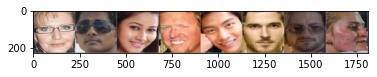

female  male female  male  male  male  male female


In [7]:
#Посмотрим на наши данные
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
#Импортируем предобученную модель
model_resnet34 = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)

Using cache found in C:\Users\Owner/.cache\torch\hub\pytorch_vision_master


In [9]:
#"Замораживаем" все слои кроме Batch normalization т.к они обучены на мат.ожид и дисперсию из ImageNet
for name, param in model_resnet34.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

In [10]:
# Добавляем голову для классификации двух классов 
num_classes = 2
model_resnet34.fc = nn.Sequential(nn.Linear(model_resnet34.fc.in_features, 512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))

In [11]:
def train(model, optimizer, loss_fn, train_loader, epochs=5, device="cpu"):
    for epoch in tqdm(range(epochs)):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader)
        print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, training_loss))

In [12]:
def test_model(model):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

In [13]:
print(f'Num training baches: {len(train_loader)}')
print(f'Num test baches: {len(valid_loader)}')

Num training baches: 10001
Num test baches: 2501


In [14]:
model_resnet34.to(device)
optimizer = optim.Adam(model_resnet34.parameters(), lr=0.001)
train(model_resnet34, optimizer, torch.nn.CrossEntropyLoss(), train_loader, epochs=2, device=device)


Epoch: 0, Training Loss: 1.3018



Epoch: 1, Training Loss: 0.7637



In [15]:
test_model(model_resnet34)

correct: 19478  total: 20002
accuracy = 0.973803


In [18]:
torch.save(model_resnet34, r'C:\Users\Owner\Desktop\Classification\models\%s.pth' % datetime.datetime.now().strftime("%H_%M"))